# Solve Burgers' PDE example using Physics-Informed Neural Nets (PINNs)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd

In [12]:
class BurgersPINN(nn.Module):
    """Physics-informed neural nets (PINNS) to solve Burgers' equation."""

    def __init__(self,
                 nn_arch=[64, 32, 16, 8],
                 activation_fcn=torch.nn.Tanh,
                 misfit_fcn=torch.nn.MSELoss(),
                 domain=(-1, 1, 0, 1),
                 n_initcond_pts=128,
                 n_boundary_pts=128,
                 n_collocation_pts=1024,
                 device=None):
        """Args:
            nn_arch - number of nodes for each hidden layer of the dense NN
            activation_fcn - nn.Module nonlinearity class applied to the output
                      of hidden layer nodes (not applied to output layer)
            misfit_fcn  - training loss/objective function
            domain  - tuple of dimensions of the simulation domain with
                      format (x_lb, x_ub, t_start, t_end)
            n_initcond_pts - number of constraint boundary points
            n_boundary_pts - number of boundary points
            n_collocation_pts - number of points where to test and ensure
                      that the trained PINN solves the PDE 
            device  - compute device; defaults to "cuda:0" when available or
                      "cpu" otherwise
        """

        super().__init__()
        self._domain = domain
        self._nn_arch = nn_arch
        self._activation_fcn = activation_fcn
        self._misfit_fcn = misfit_fcn
        self._n_initcond_pts = n_initcond_pts
        self._n_boundary_pts = n_boundary_pts
        self._n_collocation_pts = n_collocation_pts

        if device:
            self._device = device
        else:
            self._device = "cuda:0" if torch.cuda.is_available() else "cpu"

        # initialize neural net representation of domain
        self._layers = []
        n_inputs = 2
        # .. add hidden layers
        for i, n_nodes in enumerate(nn_arch):
            self._layers.append(nn.Linear(n_inputs, n_nodes))
            self._layers.append(activation_fcn())
            n_inputs = n_nodes
        # .. add output layer
        self._layers.append(nn.Linear(n_inputs, 1))
        # .. combine layers
        self._model = nn.Sequential(*self._layers)

        self.to(self._device)

    def forward(self, x, t):
        return self._model(torch.cat([x, t], axis=1))

    def pde(self, x, t):
        """Burgers' PDE:
            f(x,t|u) = du/dt + u*(du/dx) - (0.01/pi)(d^2u/dx^2) = 0.
        """
        
        u = self(x, t)
        u_t = autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x, create_graph=True)[0]
        #pdb.set_trace()
        return u_t + u*u_x - (0.01/np.pi)*u_xx

    def boundary_points(self):
        """Returns a batch of boundary points for training the PINN.
        Points are returned as a tuple (x, t, u).
        """

        # boundary condition points, i.e., u(x,t), x={-1, 1}
        x = np.where(np.random.rand(self._n_boundary_pts, 1) < 0.5,
                       self._domain[0], self._domain[1])
        t = np.random.uniform(low=self._domain[2], high=self._domain[3],
                              size=(self._n_boundary_pts, 1))
        u = np.zeros_like(x)

        return (self.numpy_to_tensor(x),
                self.numpy_to_tensor(t),
                self.numpy_to_tensor(u))

    def initial_condition_points(self, ic_func=None):
        """Returns a batch of boundary points for training the PINN.
        Points are returned as a tuple (x, t, u).
        """

        if not ic_func:
            ic_func = lambda x: -np.sin(np.pi * x)

        # initial condition points, i.e., u(x,t=0)
        x = np.random.uniform(low=self._domain[0], high=self._domain[1],
                              size=(self._n_initcond_pts, 1))
        t = np.full_like(x, self._domain[2])
        u = ic_func(x)

        return (self.numpy_to_tensor(x),
                self.numpy_to_tensor(t),
                self.numpy_to_tensor(u))

    def collocation_points(self):
        """Returns a batch of random collocation points."""
        
        # randomly sample locations in the (space x time) domain 
        x =  np.random.uniform(low=self._domain[0], high=self._domain[1],
                               size=(self._n_collocation_pts, 1))
        t = np.random.rand(self._n_collocation_pts, 1)

        x = self.numpy_to_tensor(x, grad=True)
        t = self.numpy_to_tensor(t, grad=True)

        return x, t

    def get_loss(self, mse_ic, mse_bc, mse_pde):
        """Returns combined loss and dict of individual component loss values."""
        losses = {'mse_ic': mse_ic.item(),
                  'mse_bc': mse_bc.item(),
                  'mse_pde': mse_pde.item()}
        return mse_ic + mse_bc + mse_pde, losses

    def train(self, learning_rate=1e-3, n_iter=1000, disp_iter=100,
              resample_initcond_pts=False,
              resample_boundary_pts=False,
              resample_collocation_points=True):
        
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, amsgrad=True)

        f_vals = self.numpy_to_tensor(np.zeros((self._n_collocation_pts, 1)))

        for it in range(n_iter):       
            if it==0 or resample_initcond_pts:
                xic, tic, uic = self.initial_condition_points()
            if it==0 or resample_boundary_pts:
                xbc, tbc, ubc = self.boundary_points()
            if it==0 or resample_collocation_points:
                x_col, t_col = self.collocation_points()

            # loss on initial condition points
            pred_uic = self(xic, tic)
            mse_ic = self._misfit_fcn(uic, pred_uic)

            # loss on boundary points
            pred_ubc = self(xbc, tbc)
            mse_bc = self._misfit_fcn(ubc, pred_ubc)

            # loss on collocation points
            pred_f = self.pde(x_col, t_col)
            mse_pde = self._misfit_fcn(f_vals, pred_f)

            # combined loss
            loss, losses = self.get_loss(mse_ic, mse_bc, mse_pde)

            # backprop + gradient step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if it % disp_iter == 0:
                print(f'[{it:5d}]',
                      ' '.join([f'{ln}={lv:.5f},' for ln, lv in losses.items()]),
                      f'loss={loss:.5f}')

    def numpy_to_tensor(self, x, grad=False):
        return torch.from_numpy(x).float().requires_grad_(grad).to(self._device)

In [13]:
np.random.seed(1)
torch.manual_seed(1)

pinn = BurgersPINN()
print(pinn)

pinn.train(learning_rate=0.001, n_iter=14001, disp_iter=200)

BurgersPINN(
  (_misfit_fcn): MSELoss()
  (_model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
[    0] mse_ic=0.44542, mse_bc=0.00313, mse_pde=0.00009, loss=0.44864
[  200] mse_ic=0.06540, mse_bc=0.00384, mse_pde=0.04650, loss=0.11574
[  400] mse_ic=0.05460, mse_bc=0.00059, mse_pde=0.03505, loss=0.09024
[  600] mse_ic=0.04727, mse_bc=0.00036, mse_pde=0.03172, loss=0.07935
[  800] mse_ic=0.03239, mse_bc=0.00016, mse_pde=0.02476, loss=0.05732
[ 1000] mse_ic=0.02444, mse_bc=0.00035, mse_pde=0.02694, loss=0.05173
[ 1200] mse_ic=0.01815, mse_bc=0.00026, mse_pde=0.01636, loss=0.03476
[ 1400] mse_ic=0.01326, mse_bc=0.00012, mse_pde=0.01223, loss=0.02561
[ 1600] ms

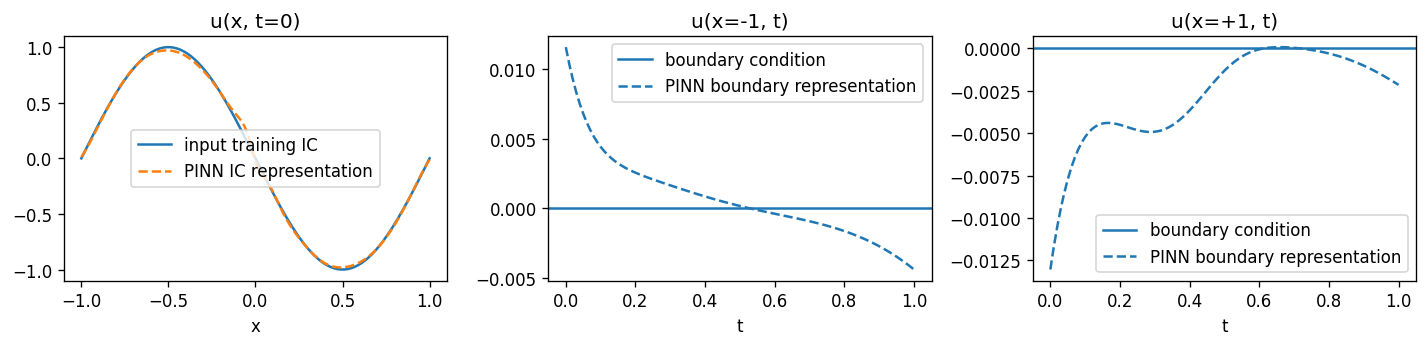

In [14]:
xg, tg = np.meshgrid(np.linspace(-1, 1, 201), np.linspace(0, 1, 101))
with torch.no_grad():
    u = pinn(pinn.numpy_to_tensor(xg.reshape((-1, 1))),
             pinn.numpy_to_tensor(tg.reshape((-1, 1))))
u = u.cpu().numpy().reshape(xg.shape)

fix, axs = plt.subplots(ncols=3, figsize=(12, 3), dpi=120)

# verify representation of initial condition
axs[0].plot(xg[0], -np.sin(np.pi*xg[0]), label='input training IC')
axs[0].plot(xg[0], u[0], '--', label='PINN IC representation')
axs[0].set_xlabel('x')
axs[0].set_title('u(x, t=0)')
axs[0].legend()

# verify accuracy of boundary conditions
axs[1].axhline(y=0, label='boundary condition')
axs[1].plot(tg[:, 0], u[:, 0], '--', label='PINN boundary representation')
axs[1].set_xlabel('t')
axs[1].set_title(r'u(x=-1, t)')
axs[1].legend()

axs[2].axhline(y=0, label='boundary condition')
axs[2].plot(tg[:, -1], u[:, -1], '--', label='PINN boundary representation')
axs[2].set_xlabel('t')
axs[2].set_title(r'u(x=+1, t)')
axs[2].legend()

plt.tight_layout()

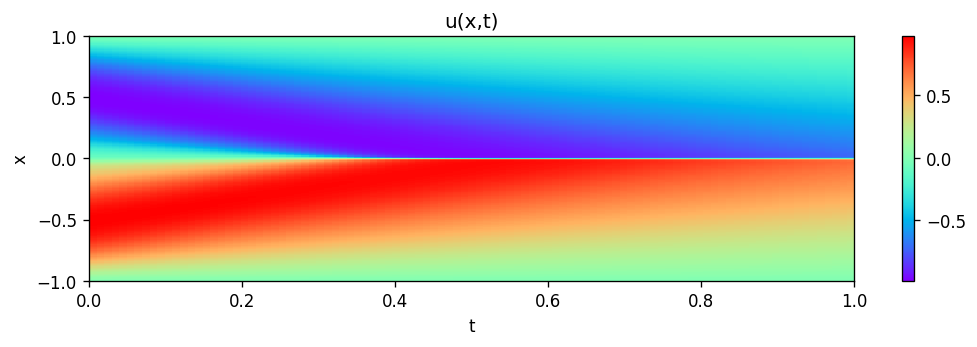

In [15]:
plt.figure(figsize=(9, 3), dpi=120)
plt.imshow(u.T,
           cmap='rainbow',
           interpolation='nearest',
           extent=[0, 1, -1, 1],
           origin='lower',
           aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout();

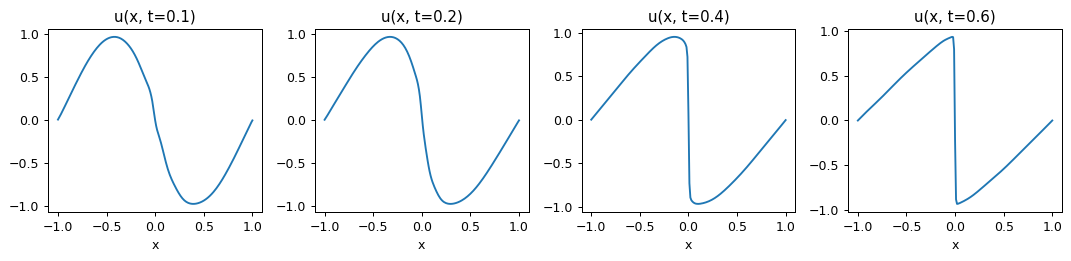

In [16]:
t_vals = [0.1, 0.2, 0.4, 0.6]

fix, axs = plt.subplots(ncols=len(t_vals), figsize=(3*len(t_vals), 3), dpi=90)
for t, ax in zip(t_vals, axs):
    xg = np.linspace(-1, 1, 201)
    with torch.no_grad():
        u = pinn(pinn.numpy_to_tensor(xg.reshape((-1, 1))),
                 pinn.numpy_to_tensor(np.full((len(xg), 1), t)))
        ax.plot(xg, u.numpy())
        ax.set_xlabel('x')
        ax.set_title(f'u(x, t={t})')
plt.tight_layout()